# DataverseNL Analysis at UM

---

This notebook connects to the DataverseNL instance at Maastricht University and generates reports on the available datasets. The pipeline is divided into three sections: Connection, Processing, and Reporting.

Contact: rdm-services@ma.nl  
License: MIT License  
Documentation: [pyDataverse](https://pydataverse.readthedocs.io/)


In [ ]:
#!pip install -U pyDataverse==0.3.1
#!pip install plotly_express==0.4.0
#!pip install -U kaleido

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyDataverse.api import NativeApi
import requests
import json
from datetime import datetime

# Utility function to generate filenames with timestamps
def generate_filename(base_name, extension):
    date_str = datetime.now().strftime("%Y%m%d")
    return f"{base_name}-{date_str}.{extension}"

---
## 1) Connection to Dataverse API
A connection to the DataverseNL API is established using an API token for authentication. The token file should be manually added. A basic query is performed to confirm the successful connection.

In [5]:
DATAVERSE_URL = 'https://dataverse.nl/dataverse/maastricht'

# You need a token from Dataverse (store in TOKEN.txt)
with open('TOKEN.txt', 'r') as file:
    API_TOKEN = file.read().strip()

BASE_URL = DATAVERSE_URL.split('/dataverse/')[0]
DATAVERSE_ID = DATAVERSE_URL.split('/dataverse/')[1]

# Connect to the API
api = NativeApi(BASE_URL, API_TOKEN)

# Test the connection
resp = api.get_info_version()
assert resp.json()['status'] == 'OK', "Failed to connect to Dataverse API"
print('Successful connection to DataverseNL API!!')

Successful connection to DataverseNL API!!


---
## 2) Data Processing: Wranginlg Dataverse University Tree
The Dataverse tree structure is loaded and parsed to extract information on faculties, departments, and their datasets. Relevant metadata, such as publication dates and persistent URLs, is collected and organized into a structured format.

In [7]:
json_file = generate_filename('dataverse_tree', 'json')
json_path = f'data/{json_file}'

# If the JSON file doesn't exist, fetch data from Dataverse API and save it
if not os.path.exists(json_path):
    # Fetch the data from the API and store it as `tree_data`
    tree_data = api.get_children(DATAVERSE_ID, children_types=['dataverses', 'datasets'])

    # Save the fetched data to a JSON file
    with open(json_path, 'w') as f:
        json.dump(tree_data, f)

    # Load the `tree` from the fetched data
    tree = tree_data
else:
    # If the file exists, load the tree from the JSON file
    with open(json_path, 'r') as f:
        tree = json.load(f)

# Function to retrieve datasets from a dataverse
def get_datasets(dataverse):
    dataverse_id = dataverse['dataverse_id']
    headers = {"X-Dataverse-key": API_TOKEN}
    url = f"{BASE_URL}/api/dataverses/{dataverse_id}/contents"
    response = requests.get(url, headers=headers)
    response_json = response.json()
    
    if 'data' not in response_json:
        print(f"Data key not found for {dataverse_id}")
        return {'data': []}
    
    return response_json


In [8]:
# Function to recursively process datasets, handling both departments and sub-departments
def process_datasets(parent_name, children, datasets_list, department_name):
    for child in children:
        if child['type'] == 'dataverse':
            sub_dataverse_name = child['title']
            datasets = get_datasets(child)
            for dataset in datasets['data']:
                publicationDate = dataset.get('publicationDate')
                persistent_url = dataset.get('persistentUrl')
                if publicationDate and persistent_url:
                    dataset_info = {
                        'faculty': parent_name,
                        'department': department_name,
                        'sub_dataverse': sub_dataverse_name,
                        'year': publicationDate[0:4],
                        'date': publicationDate,
                        'persistentUrl': persistent_url
                    }
                    datasets_list.append(dataset_info)

            # Recursive call: If the sub-department has sub-departments
            if 'children' in child and child['children']:
                process_datasets(parent_name, child['children'], datasets_list, department_name)

# Main extraction logic
datasets_list = []
for faculty in tree:
    if faculty['type'] != 'dataverse':
        continue
    faculty_name = faculty['title']
    has_departments = False

    # Process departments if they exist
    for department in faculty['children']:
        if department['type'] != 'dataverse':
            continue
        has_departments = True
        department_name = department['title']
        datasets = get_datasets(department)
        for dataset in datasets['data']:
            publicationDate = dataset.get('publicationDate')
            persistent_url = dataset.get('persistentUrl')
            if publicationDate and persistent_url:
                dataset_info = {
                    'faculty': faculty_name,
                    'department': department_name,
                    'sub_dataverse': 'No sub-dataverse',  # Default to "no sub-dataverse" at department level
                    'year': publicationDate[0:4],
                    'date': publicationDate,
                    'persistentUrl': persistent_url
                }
                datasets_list.append(dataset_info)

        # Check if department has sub-departments and process recursively
        if 'children' in department and department['children']:
            process_datasets(faculty_name, department['children'], datasets_list, department_name)

    # If no departments, process datasets directly under the faculty
    if not has_departments:
        department_name = 'No department'
        datasets = get_datasets(faculty)
        for dataset in datasets['data']:
            publicationDate = dataset.get('publicationDate')
            persistent_url = dataset.get('persistentUrl')
            if publicationDate and persistent_url:
                dataset_info = {
                    'faculty': faculty_name,
                    'department': department_name,
                    'sub_dataverse': 'No sub-dataverse',  # No sub-department
                    'year': publicationDate[0:4],
                    'date': publicationDate,
                    'persistentUrl': persistent_url
                }
                datasets_list.append(dataset_info)

# Convert to DataFrame
df = pd.DataFrame(datasets_list)

# Save the DataFrame to Excel
overview_file = generate_filename('dataverse_overview', 'xlsx')
df.to_excel(f'data/{overview_file}')

# Test if data was successfully loaded
assert not df.empty, "No datasets found."
print(f"Datasets loaded: {len(df)}")

Datasets loaded: 631


---
## 3) Reporting: Generating the University Overview
Cumulative and relative dataset reports are generated, grouped by faculty and year. Visualizations, including bar plots and heatmaps, are created, with filenames automatically incorporating the current date for documentation purposes.

In [10]:
faculty_dict = {
    'Faculty of Psychology and Neuroscience': 'FPN',
    'School of Business and Economics': 'SBE',
    'Faculty of Health, Medicine & Life Sciences': 'FHML',
    'Faculty of Arts and Social Sciences': 'FASoS',
    'Faculty of Law': 'FdR',
    'Faculty of Science and Engineering': 'FSE',
    'UNU-MERIT': 'UNU-MERIT',
    'DataHub': 'MUMC+',
    'Maastricht UMC+': 'MUMC+'
}

df.faculty = df.faculty.replace(faculty_dict)
df['count'] = 1
df_grouped = df.groupby(['faculty', 'year'])['count'].sum().reset_index()
df_pivot = df_grouped.pivot(index='faculty', columns='year', values='count').fillna(0)

absolute_file = generate_filename('dataverse_absolute', 'xlsx')
df_pivot.to_excel(f'data/{absolute_file}')

df_relative = df_pivot.apply(lambda x: (x / x.sum() * 100).round(2), axis=1)
relative_file = generate_filename('dataverse_relative', 'xlsx')
df_relative.to_excel(f'data/{relative_file}')

print(f"Absolute data saved to: {absolute_file}")
print(f"Relative data saved to: {relative_file}")

Absolute data saved to: dataverse_absolute-20240925.xlsx
Relative data saved to: dataverse_relative-20240925.xlsx


Heatmap saved to: plots/heatmapRelative-20240925.png


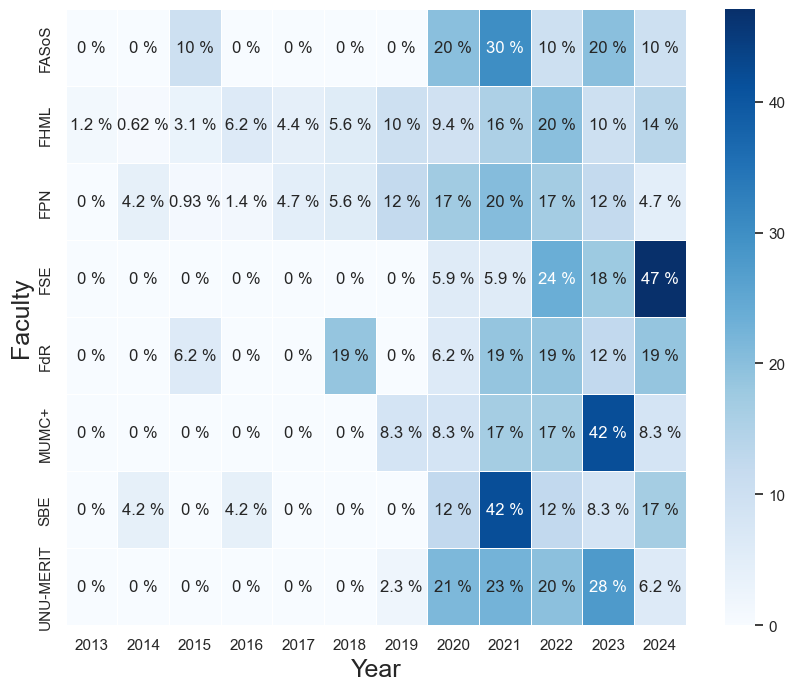

In [34]:
cmap = sns.color_palette("Blues", as_cmap=True)
sns.set(font_scale=1)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_relative, cmap=cmap, annot=True, linewidths=0.5, ax=ax)

for t in ax.texts: 
    t.set_text(t.get_text() + " %")

ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Faculty', fontsize=18)

filename = generate_filename('heatmapRelative', 'png')
plt.savefig(f'plots/{filename}', dpi=300, bbox_inches='tight')
print(f"Heatmap saved to: plots/{filename}")

/var/folders/__/cfs5pm1964z115b7n641sb_c0000gn/T/ipykernel_35587/2055136176.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='year', y='cumulative', data=counts, color=color, ax=ax, palette="Blues_d")


Bar plot saved to: plots/runningTotal-20240925.png


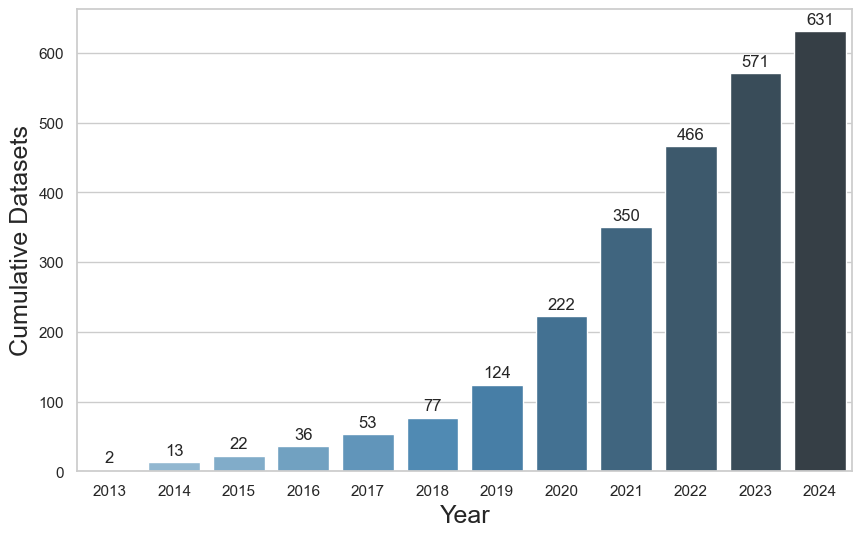

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set color palette and style
cmap = sns.color_palette("Blues", as_cmap=False)
color = cmap[-2]
sns.set_style("whitegrid")

# Group the data by year and get counts
counts = df.groupby('year').size().reset_index(name='count')
counts['cumulative'] = counts['count'].cumsum()

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = sns.barplot(x='year', y='cumulative', data=counts, color=color, ax=ax, palette="Blues_d")

# Add labels to the top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, padding=3)

# Set labels and font size
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Cumulative Datasets', fontsize=18)

# Save the plot with auto-generated filename
filename = generate_filename('runningTotal', 'png')
plt.savefig(f'plots/{filename}', dpi=300, bbox_inches='tight')
print(f"Bar plot saved to: plots/{filename}")

Area chart saved to: plots/faculty_contributions_area_chart_labeled-20240925.png


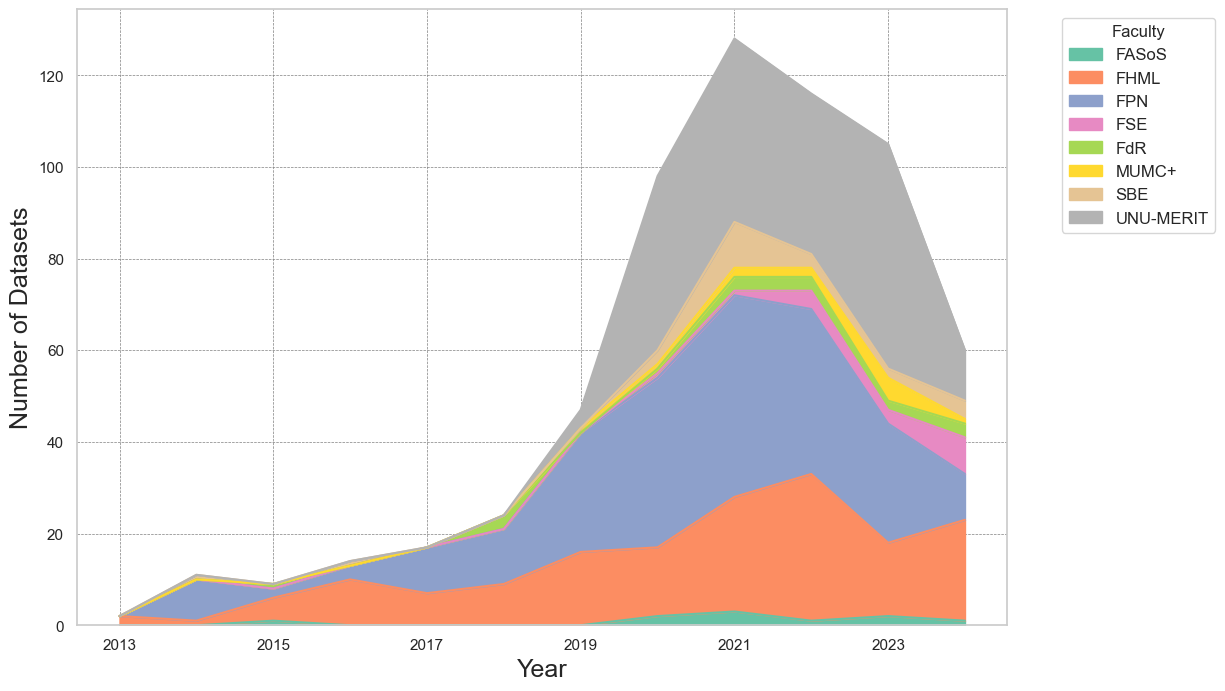

In [30]:
df_grouped = df.groupby(['faculty', 'year']).size().unstack('year').fillna(0)

# Plot the stacked area chart with a gentler color palette
fig, ax = plt.subplots(figsize=(12, 8))
df_grouped.T.plot(kind='area', stacked=True, ax=ax, color=sns.color_palette("Set2", len(df_grouped)))

# Set labels and title
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Number of Datasets', fontsize=18)

# Add gridlines
ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

# Adjust legend placement
ax.legend(title='Faculty', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Save the plot with the automatically generated filename
filename = generate_filename('faculty_contributions_area_chart_labeled', 'png')
plt.savefig(f'plots/{filename}', dpi=300, bbox_inches='tight')
print(f"Area chart saved to: plots/{filename}")

Heatmap saved to: plots/monthly_dataset_activity_heatmap-20240925.png


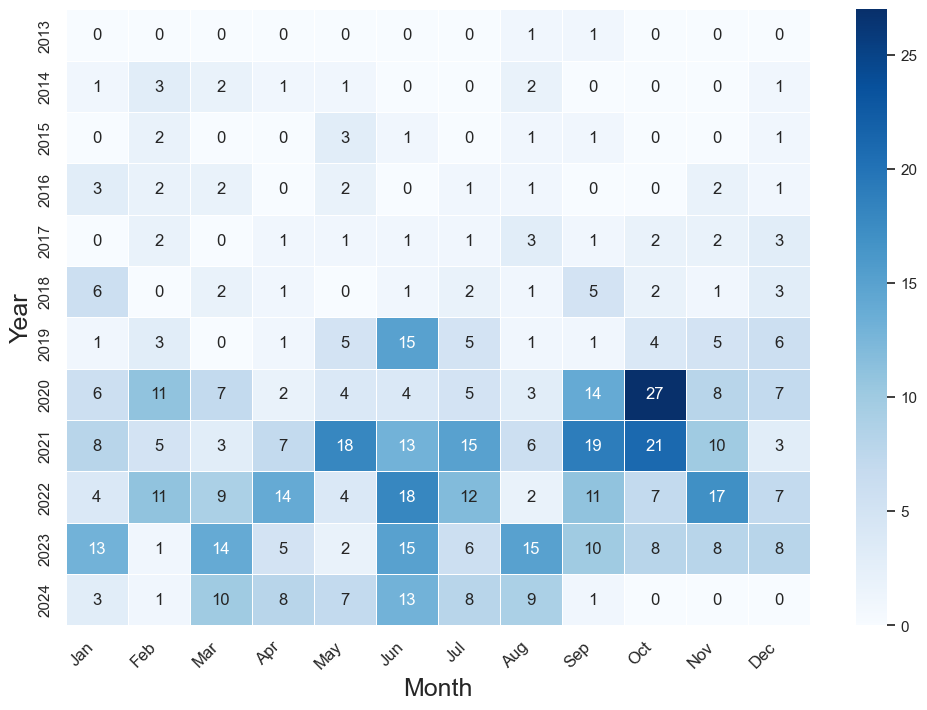

In [38]:
df['month'] = pd.to_datetime(df['date']).dt.month
df_monthly = df.groupby(['year', 'month']).size().unstack('month').fillna(0)

cmap = sns.color_palette("Blues", as_cmap=True)
sns.set(font_scale=1)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_monthly, cmap=cmap, annot=True, linewidths=0.5, ax=ax, fmt='.0f')

ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Year', fontsize=18)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(month_labels, rotation=45, ha='right', fontsize=12)

filename = generate_filename('monthly_dataset_activity_heatmap', 'png')
plt.savefig(f'plots/{filename}', dpi=300, bbox_inches='tight')
print(f"Heatmap saved to: plots/{filename}")